## 2-数据探索

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

D:\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# 定义文件名
ACTION_201602_FILE = "data/JData_Action_201602.csv"
ACTION_201603_FILE = "data/JData_Action_201603.csv"
ACTION_201604_FILE = "data/JData_Action_201604.csv"
COMMENT_FILE = "data/JData_Comment.csv"
PRODUCT_FILE = "data/JData_Product.csv"
USER_FILE = "data/JData_User.csv"

USER_TABLE_FILE = "data/user_table.csv"
ITEM_TABLE_FILE = "data/item_table.csv"

### 周一到周日各天购买情况
不同的时间购买情况不同，我们分析出其中的规律。

比如我们分析出周四、周五的购买量大（京东送货速度快，一般这时候购买周末收货），亦或者周一周二买，上班回来顺便拿，那么即使预测这些时间的购买概率低，我们也可以人为的往上提一点。

In [3]:
# 提取购买(type=4)的行为数据
def get_from_action_data(fname, chunk_size=50000):
    reader = pd.read_csv(fname, header=0, iterator=True)
    chunks = []
    loop = True
    while loop:
        try:
            chunk = reader.get_chunk(chunk_size)[
                ["user_id", "sku_id", "type", "time"]]
            chunks.append(chunk)
        except StopIteration:
            loop = False
            print("Iteration is stopped")
 
    df_ac = pd.concat(chunks, ignore_index=True)
    # type=4,为购买
    df_ac = df_ac[df_ac['type'] == 4]
 
    return df_ac[["user_id", "sku_id", "time"]]

In [4]:
df_ac = []
df_ac.append(get_from_action_data(fname=ACTION_201602_FILE))
df_ac.append(get_from_action_data(fname=ACTION_201603_FILE))
df_ac.append(get_from_action_data(fname=ACTION_201604_FILE))
df_ac = pd.concat(df_ac, ignore_index=True)

Iteration is stopped
Iteration is stopped
Iteration is stopped


In [5]:
print(df_ac.dtypes)

user_id     int64
sku_id      int64
time       object
dtype: object


In [6]:
# 将time字段转换为datetime类型
df_ac['time'] = pd.to_datetime(df_ac['time'])

# 使用lambda匿名函数将时间time转换为星期(周一为1, 周日为７)
df_ac['time'] = df_ac['time'].apply(lambda x: x.weekday() + 1)

In [7]:
df_ac.head()

,user_id,sku_id,time
0,269365,166345,1
1,235443,36692,1
2,247689,9112,1
3,273959,102034,1
4,226791,163550,1


In [11]:
# 周一到周日每天购买用户个数
df_user = df_ac.groupby('time')['user_id'].nunique() # 统计购买的用户，而不是购买量 
df_user = df_user.to_frame().reset_index()
df_user.columns = ['weekday', 'user_num']
df_user

,weekday,user_num
0,1,6162
1,2,6946
2,3,5001
3,4,6409
4,5,6049
5,6,4174
6,7,3710


In [12]:
# 周一到周日每天购买商品个数
df_item = df_ac.groupby('time')['sku_id'].nunique()
df_item = df_item.to_frame().reset_index()
df_item.columns = ['weekday', 'item_num']
df_item

,weekday,item_num
0,1,1844
1,2,1996
2,3,1800
3,4,1805
4,5,1855
5,6,1643
6,7,1578


In [14]:
# 周一到周日每天购买记录个数
df_ui = df_ac.groupby('time', as_index=False).size()
df_ui = df_ui.to_frame().reset_index()
df_ui.columns = ['weekday', 'user_item_num']
df_ui

,weekday,user_item_num
0,1,7759
1,2,8869
2,3,6262
3,4,8078
4,5,7505
5,6,5143
6,7,4636


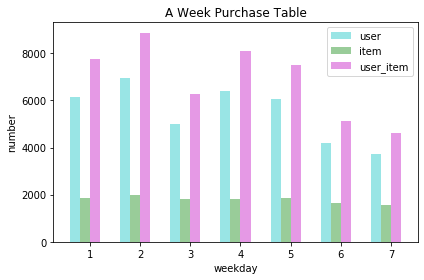

In [15]:
# 条形宽度
bar_width = 0.2
# 透明度
opacity = 0.4
 
plt.bar(df_user['weekday'], df_user['user_num'], bar_width, alpha=opacity, color='c', label='user')
plt.bar(df_item['weekday']+bar_width, df_item['item_num'], bar_width, alpha=opacity, color='g', label='item')
plt.bar(df_ui['weekday']+bar_width*2, df_ui['user_item_num'], bar_width, alpha=opacity, color='m', label='user_item')
 
plt.xlabel('weekday')
plt.ylabel('number')
plt.title('A Week Purchase Table')
plt.xticks(df_user['weekday'] + bar_width * 3 / 2., (1,2,3,4,5,6,7))
plt.tight_layout() 
plt.legend(prop={'size':10})

user是用户数，item是商品数，user_item是购买记录。

从当前情况看，周二是最高值，周三是最低值。从总体来看工作日的购买情况比周末高。